# Analysis of performance on openset binary problems

TODO:
- per antigen patterns over all problems

In [1]:
from pathlib import Path
import re
from typing import List
import json
import numpy as np
import pandas as pd
# import dovpanda
import matplotlib.pyplot as plt
import seaborn as sns
import requests

import mlflow


from NegativeClassOptimization import utils

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## MLFLOW API

In [2]:
response = requests.get("http://10.40.3.22:5000/api/2.0/mlflow/experiments/list")
response.json()

{'experiments': [{'experiment_id': '3',
   'name': '06b',
   'artifact_location': 'ftp://eugen:33bY@U&ld&We@10.40.3.22/artifacts_store/3',
   'lifecycle_stage': 'active'},
  {'experiment_id': '4',
   'name': '[TO_REMOVE] 06b_tuned',
   'artifact_location': 'ftp://eugen:33bY@U&ld&We@10.40.3.22/artifacts_store/4',
   'lifecycle_stage': 'active'},
  {'experiment_id': '8',
   'name': '06c - NDB1 asymmetry',
   'artifact_location': 'ftp://eugen:33bY@U&ld&We@10.40.3.22/artifacts_store/8',
   'lifecycle_stage': 'active'},
  {'experiment_id': '7',
   'name': '08b - Multiclass Absolut',
   'artifact_location': 'ftp://eugen:33bY@U&ld&We@10.40.3.22/artifacts_store/7',
   'lifecycle_stage': 'active'},
  {'experiment_id': '9',
   'name': '08b - Multilabel',
   'artifact_location': 'ftp://eugen:33bY@U&ld&We@10.40.3.22/artifacts_store/9',
   'lifecycle_stage': 'active'},
  {'experiment_id': '0',
   'name': 'TEST',
   'artifact_location': 'ftp://eugen:33bY@U&ld&We@10.40.3.22/artifacts_store/0',
   'li

In [3]:
response = requests.get("http://10.40.3.22:5000/api/2.0/mlflow/runs/get?run_id=d1a741062ddf441d8f3206fe4f1ed5c2")
response.json()

{'run': {'info': {'run_uuid': 'd1a741062ddf441d8f3206fe4f1ed5c2',
   'experiment_id': '5',
   'user_id': 'eugen',
   'status': 'FINISHED',
   'start_time': 1664651553411,
   'end_time': 1664652719577,
   'artifact_uri': 'ftp://eugen:33bY@U&ld&We@10.40.3.22/artifacts_store/5/d1a741062ddf441d8f3206fe4f1ed5c2/artifacts',
   'lifecycle_stage': 'active',
   'run_id': 'd1a741062ddf441d8f3206fe4f1ed5c2'},
  'data': {'metrics': [{'key': 'open_acc',
     'value': 0.7224386506030303,
     'timestamp': 1664652714194,
     'step': 0},
    {'key': 'train_loss',
     'value': 0.011984758079051971,
     'timestamp': 1664652700047,
     'step': 50},
    {'key': 'open_precision',
     'value': 0.2632753788536422,
     'timestamp': 1664652714194,
     'step': 0},
    {'key': 'closed_recall',
     'value': 0.9837615123606398,
     'timestamp': 1664652700047,
     'step': 50},
    {'key': 'open_f1',
     'value': 0.32999145099867877,
     'timestamp': 1664652714194,
     'step': 0},
    {'key': 'open_reca

## Binary problems

In [4]:
api = utils.MlflowAPI()

api.mlflow_request("5", "v.0.1.1_dev_3")
assert len(api.response["runs"]) == 602

In [5]:
df = api.build_mlflow_results_df()

df["ag_pos"] = list(map(utils.extract_antigens_from_string, df["ag_pos"]))
df["ag_neg"] = list(map(utils.extract_antigens_from_string, df["ag_neg"]))
df["ag_pos_len"] = df["ag_pos"].str.len()
df["ag_neg_len"] = df["ag_neg"].str.len()
df["ag_len"] = df["ag_pos_len"] + df["ag_neg_len"]

print(df.columns)
df.head(2)

Index(['sample_train', 'optimizer_type', 'ag_neg', 'batch_size', 'epochs',
       'N_open', 'N_closed', 'N_train', 'ag_pos', 'sample', 'learning_rate',
       'weight_decay', 'momentum', 'open_acc', 'train_loss', 'open_precision',
       'closed_recall', 'open_f1', 'open_recall', 'open_avg_precision',
       'closed_f1', 'closed_precision', 'test_acc', 'open_fpr_naive_model',
       'test_loss', 'open_roc_auc', 'open_fpr_abs_logit_model',
       'closed_roc_auc', 'mlflow.source.git.commit', 'mlflow.note.content',
       'mlflow.source.type', 'mlflow.runName', 'mlflow.source.name',
       'mlflow.log-model.history', 'mlflow.user', 'ag_pos_len', 'ag_neg_len',
       'ag_len'],
      dtype='object')


,sample_train,optimizer_type,ag_neg,batch_size,epochs,N_open,N_closed,N_train,ag_pos,sample,...,mlflow.source.git.commit,mlflow.note.content,mlflow.source.type,mlflow.runName,mlflow.source.name,mlflow.log-model.history,mlflow.user,ag_pos_len,ag_neg_len,ag_len
0,70000,Adam,[1FBI],64,50,131283,24016,70278,"[1NSN, 1OB1, 1WEJ, 3VRL, 5E94]",None,...,9d63c0e3c6c62f95fdd383e21546d080e88c4c0e,"['1NSN', '1OB1', '1WEJ', '3VRL', '5E94'] vs ['...",LOCAL,v.0.1.1_dev_3,scripts/script_07_SN10_openset_NDBK.py,"[{""run_id"": ""d1a741062ddf441d8f3206fe4f1ed5c2""...",eugen,5,1,6
1,70000,Adam,[1NSN],64,50,131283,24016,70278,"[1FBI, 1OB1, 1WEJ, 3VRL, 5E94]",None,...,9d63c0e3c6c62f95fdd383e21546d080e88c4c0e,"['1FBI', '1OB1', '1WEJ', '3VRL', '5E94'] vs ['...",LOCAL,v.0.1.1_dev_3,scripts/script_07_SN10_openset_NDBK.py,"[{""run_id"": ""8a980ff40881447582c1d0bdf607b96a""...",eugen,5,1,6


<AxesSubplot:xlabel='closed_f1', ylabel='open_f1'>

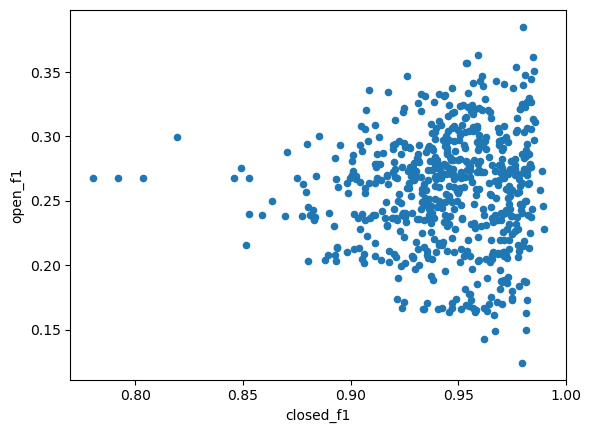

In [6]:
# df.plot.scatter(x="ag_len", y="closed_f1")
# df.plot.scatter(x="ag_len", y="open_f1")
df.plot.scatter(x="closed_f1", y="open_f1")

<AxesSubplot:xlabel='closed_f1', ylabel='open_f1'>

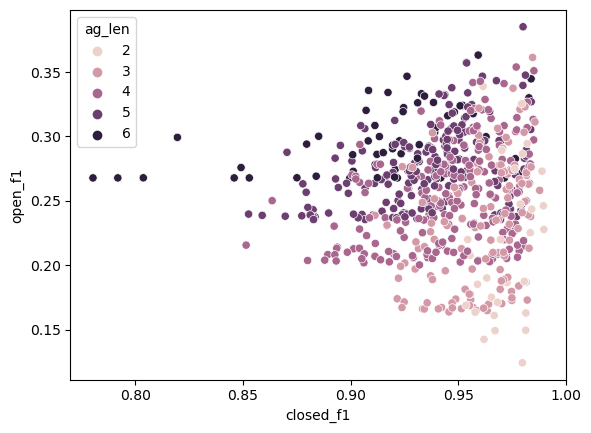

In [7]:
sns.scatterplot(
    data=df,
    x="closed_f1",
    y="open_f1",
    hue="ag_len"
)

In [8]:
from cmath import isnan


def classify_problem(series: pd.Series) -> str:
    ag_pos_len = series["ag_pos_len"]
    ag_neg_len = series["ag_neg_len"]
    

    if (not np.isnan(ag_pos_len)) and (not np.isnan(ag_neg_len)):
        if ag_pos_len == 1 and ag_neg_len == 1:
            return "NDB1"
        elif ag_pos_len == 1 and ag_neg_len > 1:
            return "NDBK"
        elif ag_pos_len > 1 and ag_neg_len == 1:
            return "NDM1"
        elif ag_pos_len > 1 and ag_neg_len > 1:
            return "NDMK"
        else:
            raise ValueError()
    else:
        return "OSK"

problem_classes = []
for i, series in df.iterrows():
    problem_classes.append(classify_problem(series))

df["problem_class"] = problem_classes
df["problem_class_len"] = df["problem_class"] + "_" + df["ag_len"].astype(str)

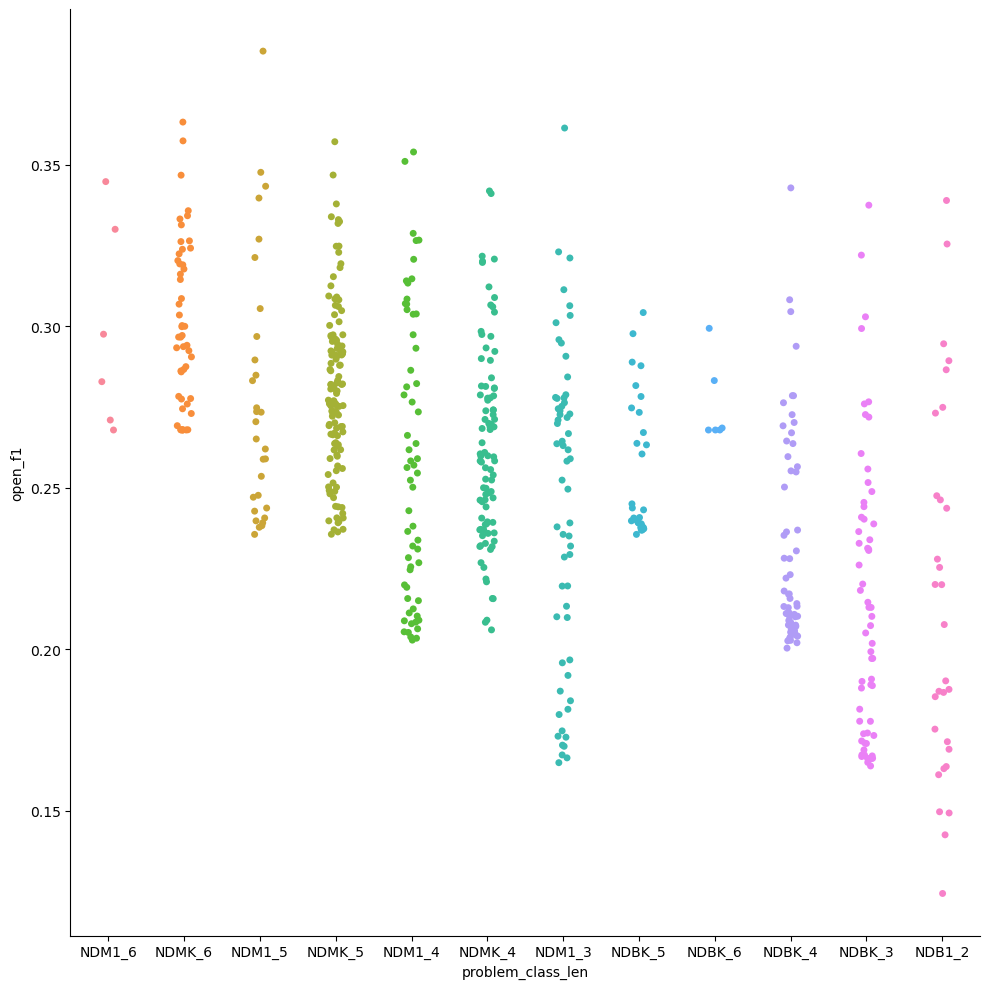

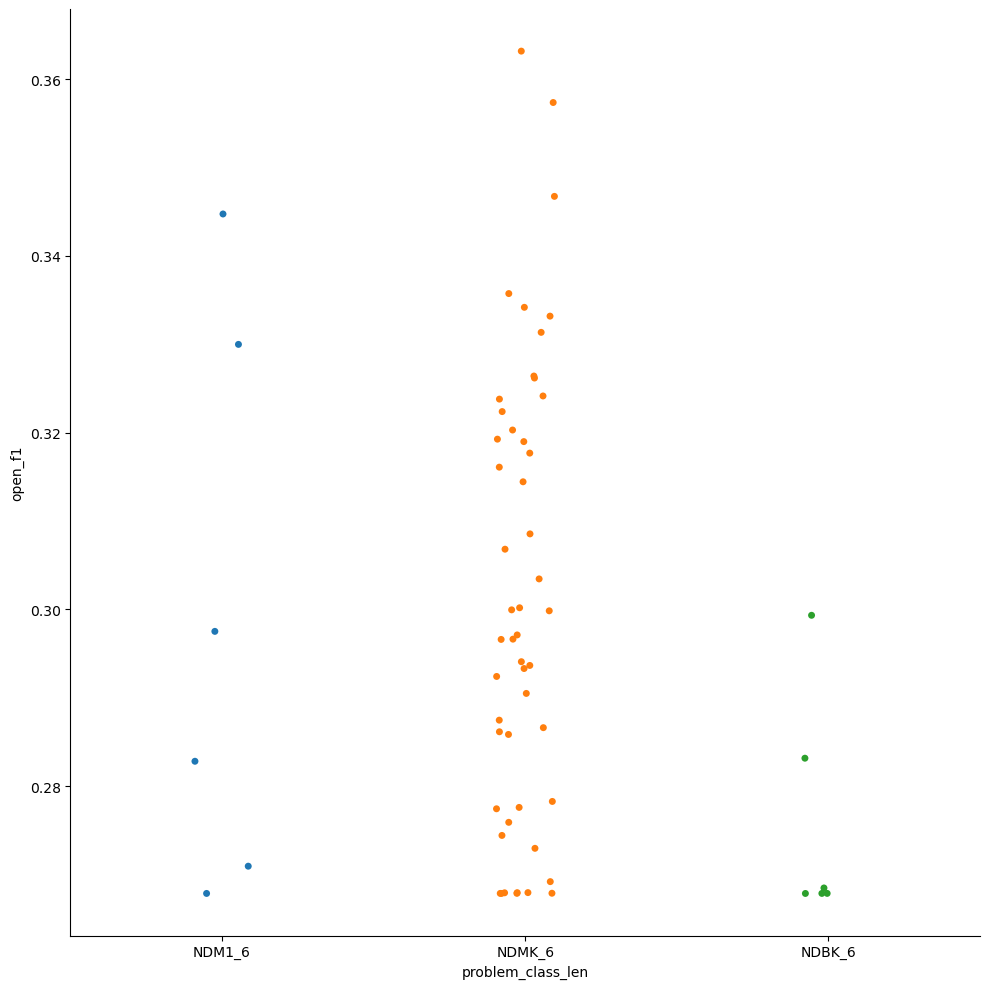

In [9]:
sns.catplot(data=df, x="problem_class_len", y="open_f1", height=10)
sns.catplot(data=df.loc[df["ag_len"] == 6], x="problem_class_len", y="open_f1", height=10)

<AxesSubplot:xlabel='problem_class_len', ylabel='open_f1'>

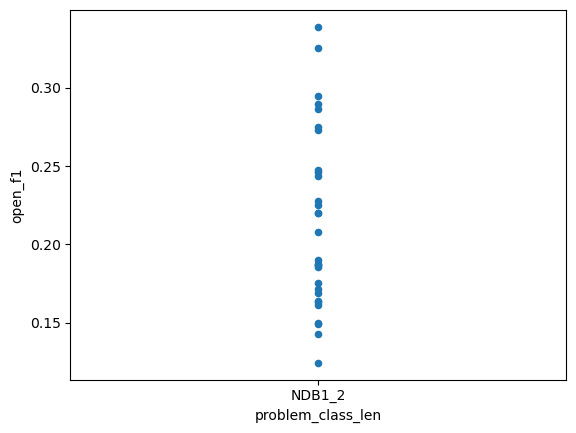

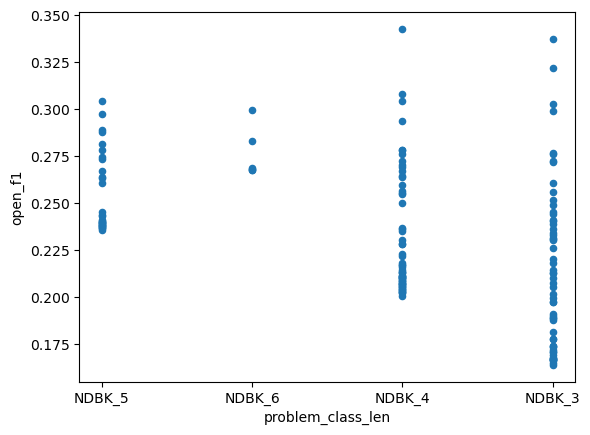

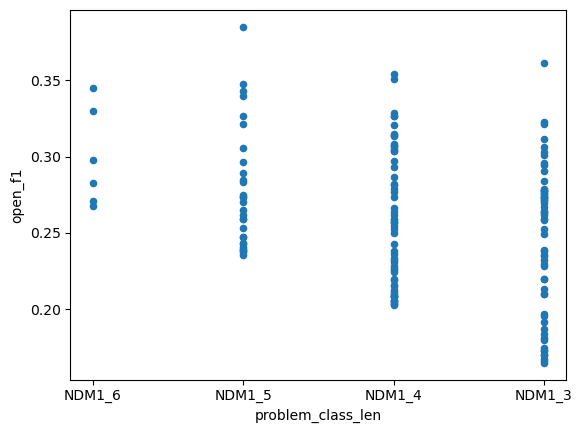

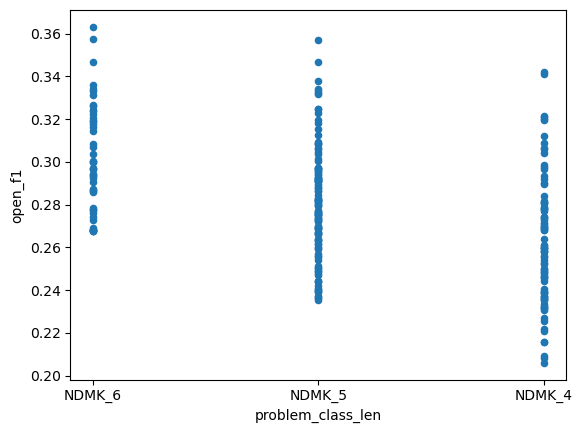

In [10]:
metric = "open_f1"
df.loc[df["problem_class"] == "NDB1"].plot.scatter(x="problem_class_len", y=metric)
df.loc[df["problem_class"] == "NDBK"].plot.scatter(x="problem_class_len", y=metric)
df.loc[df["problem_class"] == "NDM1"].plot.scatter(x="problem_class_len", y=metric)
df.loc[df["problem_class"] == "NDMK"].plot.scatter(x="problem_class_len", y=metric)

Text(0.5, 1.0, 'Open set performance: NDMK')

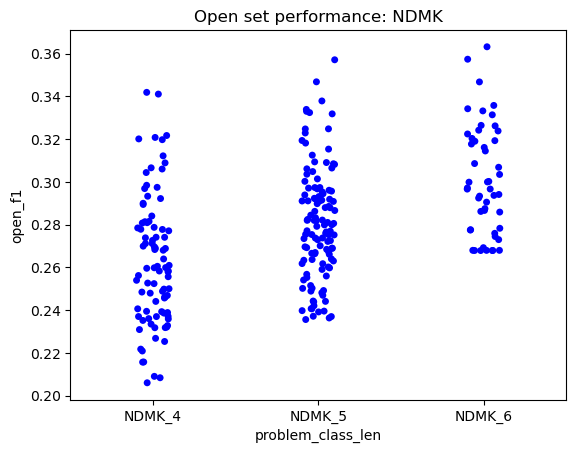

In [63]:
sns.stripplot(
    data=df.loc[df["problem_class"] == "NDMK"],
    x="problem_class_len",
    y="open_f1",
    order=["NDMK_4", "NDMK_5", "NDMK_6"],
    color="b"
    )
plt.title("Open set performance: NDMK")

<AxesSubplot:xlabel='ag_pos_len', ylabel='open_f1'>

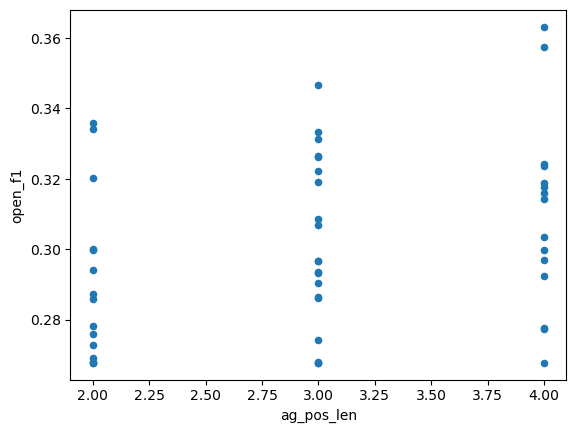

In [11]:
df_ndmk_6 = df.loc[df["problem_class_len"] == "NDMK_6"].copy()
df_ndmk_6["ag_pos_len"] = df_ndmk_6["ag_pos"].str.len()
df_ndmk_6.plot.scatter(x="ag_pos_len", y="open_f1")

## NDB1 symmetry analysis

(to be moved to notebook 11.)

Check if observed patterns correlate with `N_{train,test}`, probably this would be useful to run on 120 Ags dataset.

In [12]:
df_ndb1 = df.loc[df["problem_class"] == "NDB1"].copy()
df_ndb1["ag_pos"] = df_ndb1["ag_pos"].str[0]
df_ndb1["ag_neg"] = df_ndb1["ag_neg"].str[0]
df_ndb1["ag_comparison_id"] = df_ndb1.apply(
    lambda s: "_".join(sorted([s["ag_pos"], s["ag_neg"]])), 
    axis=1
)

Text(0.5, 1.0, 'Open_f1 difference when switching Ag+ and Ag-')

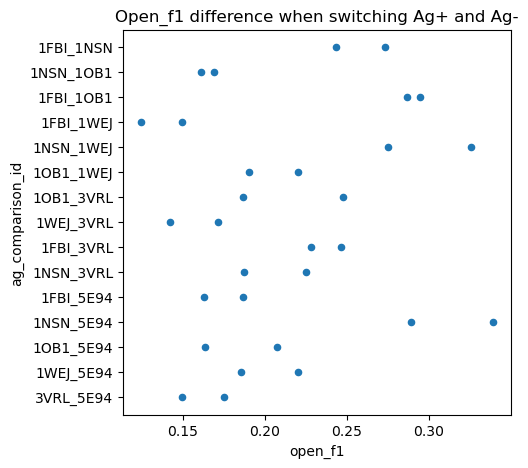

In [73]:
fig, ax = plt.subplots(figsize=(5, 5))
# df_ndb1.plot.scatter(x="ag_comparison_id", y="closed_f1")
df_ndb1.plot.scatter(y="ag_comparison_id", x="open_f1", ax=ax)
ax.set_title("Open_f1 difference when switching Ag+ and Ag-")

In [14]:
closed_f1_range = df_ndb1.groupby("ag_comparison_id")["closed_f1"].apply(lambda x: max(x) - min(x))
closed_f1_range

ag_comparison_id
1FBI_1NSN    0.004771
1FBI_1OB1    0.002246
1FBI_1WEJ    0.001557
1FBI_3VRL    0.000231
1FBI_5E94    0.008745
1NSN_1OB1    0.013127
1NSN_1WEJ    0.003194
1NSN_3VRL    0.002758
1NSN_5E94    0.008718
1OB1_1WEJ    0.006313
1OB1_3VRL    0.002853
1OB1_5E94    0.002342
1WEJ_3VRL    0.006269
1WEJ_5E94    0.004528
3VRL_5E94    0.001695
Name: closed_f1, dtype: float64

In [15]:
open_f1_range = df_ndb1.groupby("ag_comparison_id")["open_f1"].apply(lambda x: max(x) - min(x))
open_f1_range

ag_comparison_id
1FBI_1NSN    0.029450
1FBI_1OB1    0.008041
1FBI_1WEJ    0.025286
1FBI_3VRL    0.018339
1FBI_5E94    0.023599
1NSN_1OB1    0.007881
1NSN_1WEJ    0.050563
1NSN_3VRL    0.037756
1NSN_5E94    0.049608
1OB1_1WEJ    0.029840
1OB1_3VRL    0.060530
1OB1_5E94    0.043959
1WEJ_3VRL    0.028825
1WEJ_5E94    0.034684
3VRL_5E94    0.025952
Name: open_f1, dtype: float64

<AxesSubplot:xlabel='closed_f1', ylabel='open_f1'>

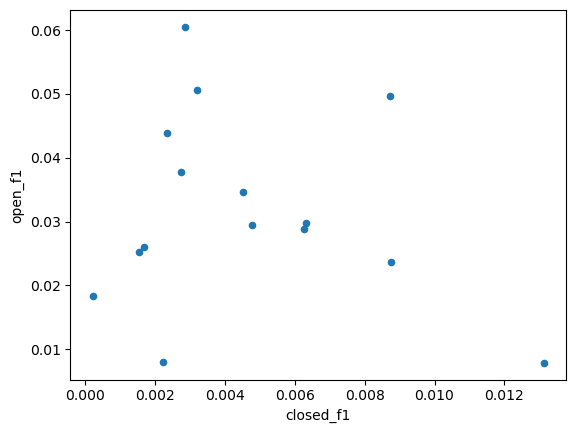

In [16]:
df_range = pd.merge(closed_f1_range, open_f1_range, how="inner", left_index=True, right_index=True)
df_range.plot.scatter(x="closed_f1", y="open_f1")

TODO: It is important to evaluate whether the model prioritizes ag_pos or ag_neg?

TODO: categorical violin plot (as at the beginning) with the extra openset metrics!

TODO: checking intersections of ag_pos, ag_neg with openset in this analysis

## Multiclass anlaysis

In [17]:
response = requests.post(
    "http://10.40.3.22:5000/api/2.0/mlflow/runs/search",
    json={
        "experiment_ids": ["6"],
        "filter": 'attributes.status = "FINISHED"',
    },
).json()

mlflow_records = [response["runs"][idx]["data"] for idx in range(len(response["runs"]))]
df_osk = pd.DataFrame.from_records(
    map(
        build_record_from_mlflow_record,
        mlflow_records,
        )
    )
print(df_osk.columns)
df_osk = df_osk.loc[df_osk["mlflow.runName"] != "v0.1.2"].copy()
df_osk.head(2)

assert df_osk.shape[0] == 42

Index(['ags', 'sample_train', 'optimizer_type', 'batch_size', 'epochs',
       'N_open', 'N_closed', 'k', 'N_train', 'sample', 'learning_rate',
       'weight_decay', 'momentum', 'encoder_classes', 'recall_weighted_closed',
       'precision_micro_closed', 'acc_balanced_closed', 'open_acc',
       'roc_auc_weighted_closed', 'acc_closed', 'recall_micro_closed',
       'f1_macro_closed', 'recall_macro_closed', 'train_loss', 'roc_auc_open',
       'avg_precision_open', 'open_precision', 'accuracy', 'open_f1',
       'mcc_closed', 'precision_open', 'acc_open', 'open_recall',
       'open_avg_precision', 'recall_open', 'f1_micro_closed', 'f1_open',
       'roc_auc_macro_closed', 'f1_weighted_closed', 'test_loss',
       'precision_weighted_closed', 'precision_macro_closed',
       'mlflow.source.git.commit', 'mlflow.note.content', 'mlflow.source.type',
       'mlflow.source.name', 'mlflow.log-model.history', 'mlflow.user',
       'mlflow.runName'],
      dtype='object')


Text(0.5, 0.98, 'OSK\nPerformance ~ num_classes')

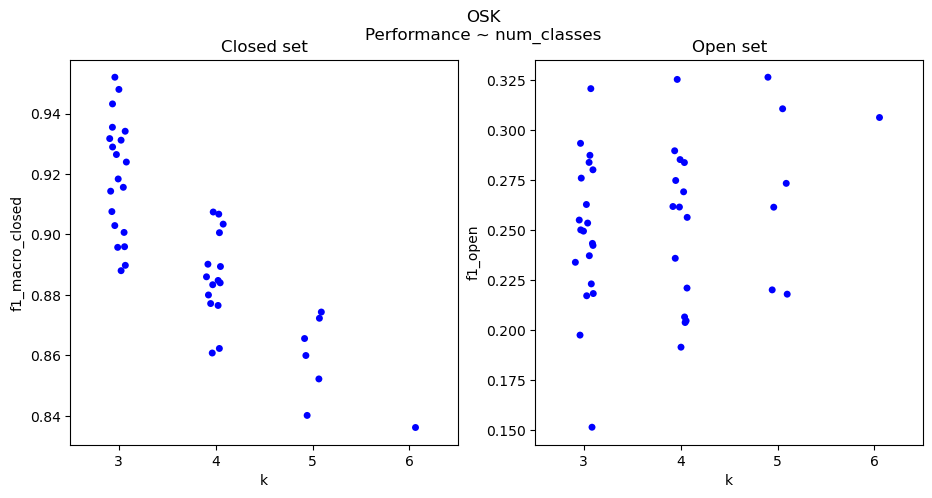

In [68]:
fig, axs = plt.subplots(ncols=2, figsize=(11, 5))

df_osk["k"] = df_osk["k"].astype(int)
sns.stripplot(
    data=df_osk,
    x="k",
    y="f1_macro_closed",
    ax=axs[0],
    color="b"
)

## Drop as f1 closed
# df_osk.plot.scatter(x="k", y="precision_macro_closed")
# df_osk.plot.scatter(x="k", y="recall_macro_closed")

sns.stripplot(
    data=df_osk,
    x="k",
    y="f1_open",
    ax=axs[1],
    color="b"
)
## Some pattern here.
# df_osk.plot.scatter(x="k", y="open_precision")
# df_osk.plot.scatter(x="k", y="open_recall")

axs[0].set_title("Closed set")
axs[1].set_title("Open set")
fig.suptitle("OSK\nPerformance ~ num_classes")

<AxesSubplot:xlabel='k', ylabel='open_recall'>

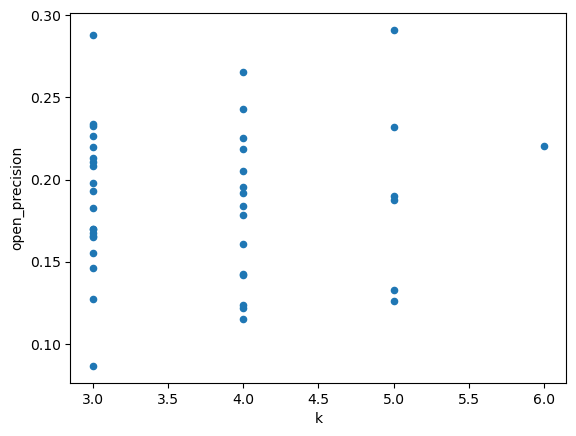

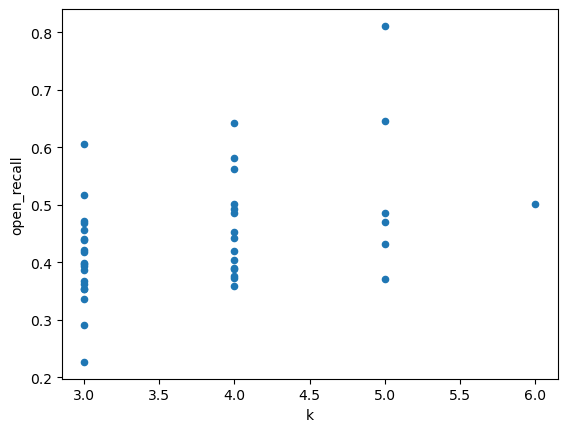

In [19]:
df_osk.plot.scatter(x="k", y="open_precision")
df_osk.plot.scatter(x="k", y="open_recall")

## Binary and multiclass

In [25]:
df_osk["ag_len"] = df_osk["k"]
df_m = pd.concat([df, df_osk], axis=0)
df_m.head(2)

,sample_train,optimizer_type,ag_neg,batch_size,epochs,N_open,N_closed,N_train,ag_pos,sample,...,mcc_closed,precision_open,acc_open,recall_open,f1_micro_closed,f1_open,roc_auc_macro_closed,f1_weighted_closed,precision_weighted_closed,precision_macro_closed
0,70000,Adam,[1FBI],64,50,131283,24016,70278,"[1NSN, 1OB1, 1WEJ, 3VRL, 5E94]",None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,70000,Adam,[1NSN],64,50,131283,24016,70278,"[1FBI, 1OB1, 1WEJ, 3VRL, 5E94]",None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
problem_classes = []
for i, series in df_m.iterrows():
    problem_classes.append(classify_problem(series))

df_m["problem_class"] = problem_classes
df_m["problem_class_len"] = df_m["problem_class"] + "_" + df_m["ag_len"].astype(str)

Text(0.5, 1.0, 'Open set performance in different closed set formulations\nSorted by median open_f1')

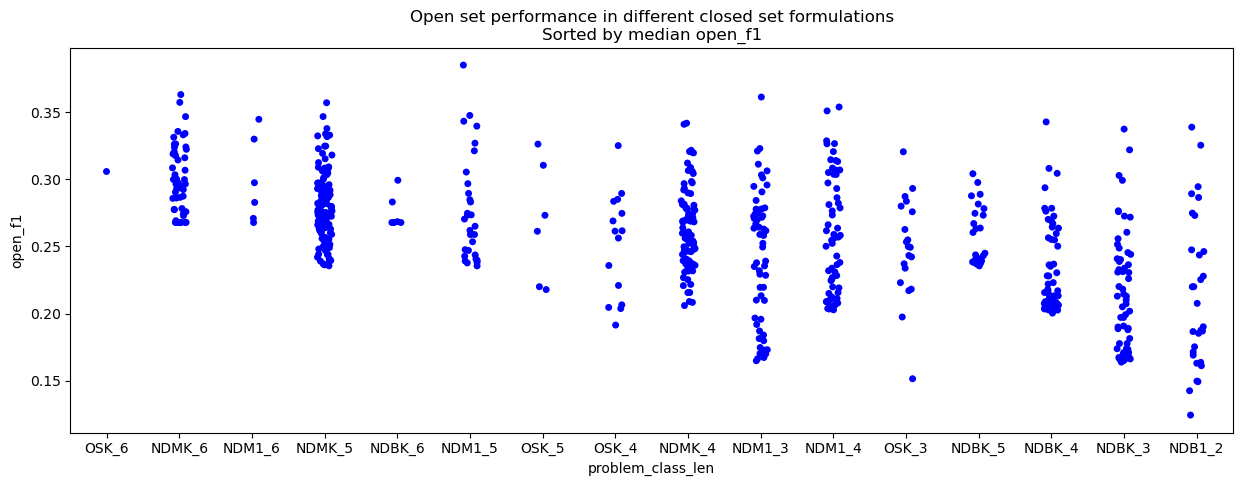

In [64]:
fig, ax = plt.subplots(figsize=(15, 5))

order = df_m.groupby("problem_class_len")["open_f1"].agg("median").sort_values(ascending=False).index.to_list()
sns.stripplot(data=df_m, x="problem_class_len", y="open_f1", order=order, ax=ax, color="b")
# sns.stripplot(data=df_m.loc[df_m["ag_len"] == 6], x="problem_class_len", y="open_f1")
ax.set_title("Open set performance in different closed set formulations\nSorted by median open_f1")

Text(0.5, 1.0, 'Open vs closed set performance')

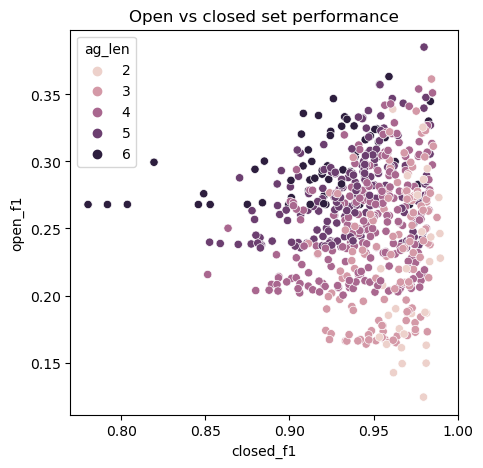

In [57]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    data=df_m,
    x="closed_f1",
    y="open_f1",
    hue="ag_len",
    ax=ax
)
ax.set_title("Open vs closed set performance")